In [1]:
from dataset import TextDataset
from rnn import RNNModel
from tokenizer import merge_text_files
from utils import add_special_tokens, collate_fn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm


In [2]:
TOKENIZER_PATH = "bpe_tokenizer.model"
TRAIN_FILE = "data/train.jsonl"
VAL_FILE = "data/test.jsonl"
MAX_SEQ_LEN = 128
BATCH_SIZE = 128
EMBEDD_DIM = 256
HIDDEN_DIM = 768
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 100


In [3]:
model = RNNModel(
    vocab_size=10000,
    embedding_dim=EMBEDD_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)

In [4]:
def train_model(model=None, name=None):
    """
    Training the model.
    """

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    # Load the tokenizer
    tokenizer = spm.SentencePieceProcessor(model_file='bpe_tokenizer.model')
    vocab_size = tokenizer.get_piece_size()

    # Load the dataset
    train_dataset = TextDataset(TRAIN_FILE, tokenizer, MAX_SEQ_LEN)
    val_dataset = TextDataset(VAL_FILE, tokenizer, MAX_SEQ_LEN)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    # optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=1, factor=0.5, verbose=True)
    criterion = nn.CrossEntropyLoss(ignore_index=3)  # Ignore padding index

    best_val_loss = float('inf')
    no_improve_epochs = 0
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0

        for input_ids, target_ids in train_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            optimizer.zero_grad()

            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input_ids, target_ids in val_loader:
                input_ids, target_ids = input_ids.to(device), target_ids.to(device)


                logits, _ = model(input_ids)
                loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Validation Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), f"best_models/pth/best_model_{name}.pth")
            print("Model saved.")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= 4:
                print("Early stopping triggered.")
                break
    print("Training complete.")
    return train_losses, val_losses


In [5]:
train_losses, val_losses = train_model(model, model._get_name())

Using device: cuda


/home/madrez/.conda/envs/fai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 6.4640
Epoch 1/100, Validation Loss: 5.8828
Model saved.
Epoch 2/100, Train Loss: 5.6285
Epoch 2/100, Validation Loss: 5.4189
Model saved.
Epoch 3/100, Train Loss: 5.2764
Epoch 3/100, Validation Loss: 5.1453
Model saved.
Epoch 4/100, Train Loss: 5.0252
Epoch 4/100, Validation Loss: 4.9758
Model saved.
Epoch 5/100, Train Loss: 4.8485
Epoch 5/100, Validation Loss: 4.8741
Model saved.
Epoch 6/100, Train Loss: 4.7093
Epoch 6/100, Validation Loss: 4.8101
Model saved.
Epoch 7/100, Train Loss: 4.6072
Epoch 7/100, Validation Loss: 4.7814
Model saved.
Epoch 8/100, Train Loss: 4.5153
Epoch 8/100, Validation Loss: 4.7455
Model saved.
Epoch 9/100, Train Loss: 4.4328
Epoch 9/100, Validation Loss: 4.7299
Model saved.
Epoch 10/100, Train Loss: 4.3646
Epoch 10/100, Validation Loss: 4.7223
Model saved.
Epoch 11/100, Train Loss: 4.3080
Epoch 11/100, Validation Loss: 4.7142
Model saved.
Epoch 12/100, Train Loss: 4.2514
Epoch 12/100, Validation Loss: 4.7162
Epoch 13/100, Train Los

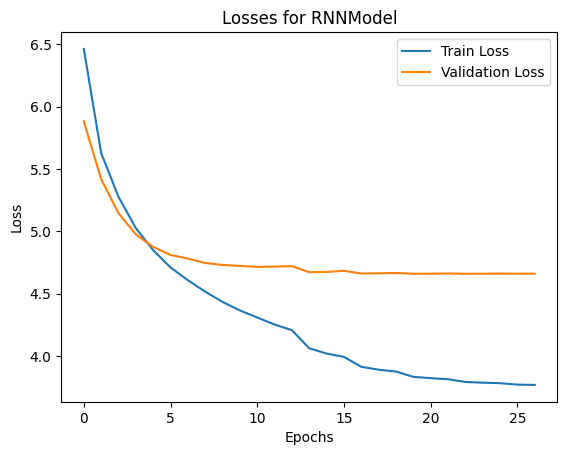

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Losses for {model._get_name()}')
plt.legend()
plt.savefig(f"best_models/img/losses_{model._get_name()}.png")
plt.show()

In [7]:
# save losses
import json
with open(f"best_models/loss/losses_{model._get_name()}.json", "w") as f:
    json.dump({"train": train_losses, "val": val_losses}, f)

In [4]:
model.load_state_dict(torch.load("best_models/pth/best_model_RNNModel.pth"))
device="cuda"
model.to(device)
model.eval()

RNNModel(
  (embedding): Embedding(10000, 256, padding_idx=0)
  (rnn): RNN(256, 768, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=768, out_features=10000, bias=True)
)

In [5]:
import sentencepiece as spm
TOKENIZER_PATH = "bpe_tokenizer.model"
tokenizer = spm.SentencePieceProcessor(model_file=TOKENIZER_PATH)
prompt = "Which do you prefer? Dogs or cats?"
model.generate(tokenizer, prompt, device="cuda")

'Which do you prefer? Dogs or cats? retorted Silver. Say what is there to strife were blamed, I am sure, it is right, said the Tin Woodman; the name was now. And I thought that if I had been struggling with his two friends, Vesoy,'

In [11]:
prompt = "Once upon a time..."
model.generate(tokenizer, prompt, device="cuda")

'Once upon a time... scarcely do yourself, the locksmith had been spreading with the brilliant sunshine. Presently she is just now round my queer form. At present, she added, you are only an orphan to makeanywherescewills? My son was a'

In [12]:
from dataset import TextDataset
from utils import collate_fn
from torch.utils.data import DataLoader
from tqdm import tqdm

MAX_SEQ_LEN = 128
BATCH_SIZE = 128

val_dataset = TextDataset(VAL_FILE, tokenizer, MAX_SEQ_LEN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

import math
criterion = nn.CrossEntropyLoss(ignore_index=3)
vocab_size = 10000
device="cuda"
def evaluate_ppl(model, data_loader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Calculating Perplexity"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    ppl = math.exp(avg_loss)
    return ppl

def evaluate_bleu(model, dataset, sp, num_samples=1000):
    model.eval()
    smoothie = SmoothingFunction().method4
    scores = []

    for i in tqdm(range(min(len(dataset), num_samples)), desc="Calculating BLEU"):
        full_text = dataset.data[i]
        # full_text = dataset.samples[i]
        prompt = full_text[:50]
        reference = full_text[50:100]
        generated_text = model.generate(tokenizer, prompt, device="cuda")

        # Compare generated text to the actual continuation
        score = sentence_bleu(
            [reference.split()],
            generated_text.split(),
            smoothing_function=smoothie
        )
        scores.append(score)

    return sum(scores) / len(scores)
# Evaluate on test set
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
ppl = evaluate_ppl(model, test_loader, criterion, vocab_size)
bleu = evaluate_bleu(model, val_dataset, tokenizer)

print(f"\nTest Perplexity: {ppl:.4f}")
print(f"Average BLEU Score (1000 samples): {bleu:.4f}")

Calculating BLEU: 100%|██████████| 1000/1000 [00:19<00:00, 50.45it/s]


Test Perplexity: 105.5257
Average BLEU Score (1000 samples): 0.0073
